In [3]:
import os
import sys
import importlib
import glob
import time
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.RationalApproximation import RationalApproximation_AAA
from scipy.special import gamma 
import scipy
from scipy.integrate import solve_ivp

import pandas as pd 

In [4]:
class MultiTermKernel: 

    def __init__(self, phis, alphas, **kwargs):
        self.phis = phis
        self.alphas = alphas

        self.RATarget = np.vectorize(self.eval_RATarget) 
        self.kernel = np.vectorize(self.eval_kernel)

    def eval_kernel(self, t):
        return np.sum(self.phis / gamma(1 - self.alphas) * t **(-self.alphas))
    
    def eval_RATarget(self, t):
        return np.sum(self.phis * t ** (1 - self.alphas))
    
# Distribution phi 
@np.vectorize
def Distribution(alpha): 
    return gamma(4 - alpha)

# Right side of the equation 
@np.vectorize
def f(t): 
    if t == 0: 
        return 0
    if t == 1: 
        return 59/3 
    return (6*t**3 + 6*t -4) / np.log(t) + (6-10*t) / np.log(t)**2 + (4*t-4) / np.log(t)**3 

# Analytical solution 
@np.vectorize
def sol_u(t): 
    return t ** 3 + 2*t + 4

In [5]:
class ODE_problem: 
    def __init__(self,beta0, beta1, beta2, poles01, weights01, poles12, weights12): 

        self.beta0 = beta0
        self.beta1 = beta1
        self.beta2 = beta2
        
        self.poles01 = poles01
        self.weights01 = weights01
        self.m01 = self.poles01.shape[0]

        self.poles12 = poles12
        self.weights12 = weights12
        self.m12 = self.poles12.shape[0]

        self.fun = np.vectorize(self.eval)

    def eval(self, t,y):
        # 0 -> u
        # 1 -> dt u 
        # 01 modes 
        # 12 modes 

        x = 0 * y

        # Derivative of u: 1 -
        x[0] = y[1]

        # Main equation  
        x[1] = -1 / self.beta2 * (self.beta0 * y[0] + self.beta1 * y[1] 
                                  - np.sum(self.poles01 * y[2:self.m01+2])
                                  + np.sum(self.poles12 ** 2 * y[self.m01+2:self.m01+self.m12+2])
                                  - f(t))

        # Mode equations 01 
        x[2:self.m01+2] = - self.poles01 * y[2:self.m01+2] + self.weights01 * y[0]

        # Mode equations 12 
        x[self.m01+2:self.m01+self.m12+2] = - self.poles12 * y[self.m01+2:self.m01+self.m12+2] + self.weights12 * y[0]

        return x 

In [6]:
#########################################
### Quadrature of the integral 
#########################################

n_QF = 2 ** 15

# interval length / (n for 0 to 1 + n for 1 to 2 + 3 for 0,1,2)
QFweight = 2 / (2*n_QF+3)
quadraturePoints01 = np.arange(0 + 0.5/n_QF,1 + 0.5/n_QF, 1/n_QF)
quadraturePoints12 = np.arange(1 + 0.5/n_QF,2 + 0.5/n_QF, 1/n_QF)

phis01 = Distribution(quadraturePoints01) * QFweight
phis12 = Distribution(quadraturePoints12) * QFweight
phi0 = Distribution(0) * QFweight
phi1 = Distribution(1) * QFweight
phi2 = Distribution(2) * QFweight

MTK01 = MultiTermKernel(phis01,quadraturePoints01)
MTK12 = MultiTermKernel(phis12,quadraturePoints12-1)

In [7]:
#########################################
### Simulation and error  
#########################################

# dts = [1e-2 * 2 ** (-i) for i in range(11)]
T  = 1
dts = [0.1 * 2**-i for i in range(10)]

error_u = [] 

for idx, dt in enumerate(dts): 

    print(idx," - ",dt)
    n_timesteps = int(np.round(T/dt)) + 1
    t = dt * np.asarray(range(n_timesteps))   

    #########################################
    ### Rational Approximation of the Integral Kernel
    #########################################

    Zmin, Zmax = 1/T,1/dt
    tol = 1.e-10
    MaxDegree = 30
    nSupportPoints = 100

    RA01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK01.RATarget)
    RA12 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK12.RATarget)

    weights01 = RA01.c
    poles01 = RA01.d
    winf01 = RA01.c_inf
    m01 = weights01.shape[0]

    weights12 = RA12.c
    poles12 = RA12.d
    winf12 = RA12.c_inf
    m12 = weights12.shape[0]

    beta0 = phi0 + np.sum(weights01) - np.sum(weights12 * poles12)
    beta1 = phi1 + np.sum(weights12) + winf01
    beta2 = phi2 + winf12

    #########################################
    ### Numerical Scheme 
    #########################################

    problem = ODE_problem(beta0, beta1, beta2, poles01, weights01, poles12, weights12)
    initial = np.zeros(10)  

    t_span = (0.,1.)
    y0 = [0] * (m01+m12+2)
    y0[0] = 4
    y0[1] = 2
    sol = solve_ivp(problem.eval, t_span, y0, method='BDF', max_step=dt, atol = 1, rtol = 1)

    #########################################
    ### Compute error 
    #########################################

    error_u.append(dt * np.linalg.norm(sol_u(sol.t) - sol.y[0]))

    # u_list.append(u)
    # v_list.append(v)
    # a_list.append(a)

    # error_u.append(dt * (np.linalg.norm(sol_u(t) - u)))
    # error_v.append(dt * (np.linalg.norm(sol_v(t) - v)))

    # for i in range(m01): 
    #     error_modes01[idx, i] = dt * (np.linalg.norm(modes01[:,i] - sol_modes(t, poles01[i], weights01[i])))
        
    # for i in range(m12): 
    #     error_modes12[idx, i] = dt * (np.linalg.norm(modes12[:,i] - sol_modes(t, poles12[i], weights12[i])))
    

0  -  0.1
1  -  0.05
2  -  0.025
3  -  0.0125
4  -  0.00625
5  -  0.003125
6  -  0.0015625
7  -  0.00078125
8  -  0.000390625
9  -  0.0001953125


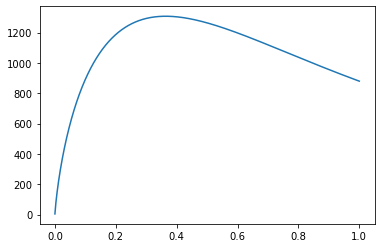

In [9]:
plt.plot(sol.t, sol.y[0])
#plt.plot(sol.t, sol.y[1])

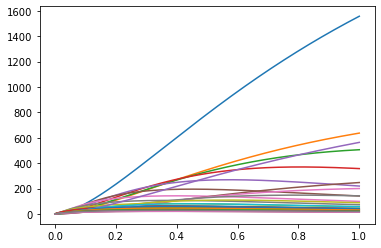

In [10]:
for i in range(2, sol.y.shape[0]): 
    plt.plot(sol.t, sol.y[i])

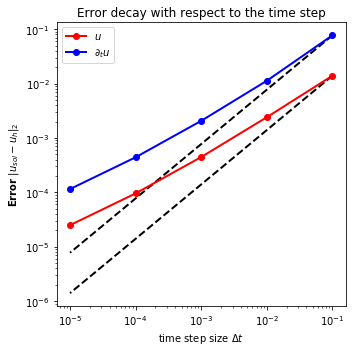

In [376]:
#########################################
### Visualization  
##########################################

fig,ax = plt.subplots(figsize = (5,5))
ax.set_title("Error decay with respect to the time step")
ax.loglog(dts, np.asarray(dts) * np.max(error_u) / np.max(dts), color = "black", linewidth = 2, linestyle="--")
ax.loglog(dts, np.asarray(dts) * np.max(error_v) / np.max(dts), color = "black", linewidth = 2, linestyle="--")
ax.loglog(dts, error_u, color = "red", linewidth = 2, marker="o", label = r"$u$")
# ax.loglog(dts[:-1], error_u_num[:-1], color = "red", linewidth = 2, marker="+", label = r"$u$")
ax.loglog(dts, error_v, color = "blue", linewidth = 2, marker="o", label = r"$\partial_t u$")
# ax.loglog(dts[:-1], error_v_num[:-1], color = "blue", linewidth = 2, marker="+", label = r"$\partial_t u$")
ax.set_xlabel(r'time step size $\Delta t$') 
ax.set_ylabel(r"Error $\|u_{sol} - u_h\|_2$", fontweight ='bold')
ax.legend() 
plt.tight_layout()
plt.savefig("ErrorDecayNewmarkEI.pdf")

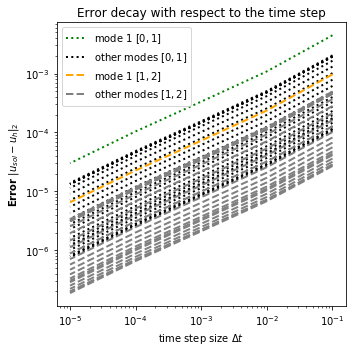

In [371]:
fig,ax = plt.subplots(figsize = (5,5))
ax.set_title("Error decay with respect to the time step")
ax.loglog(dts, error_modes01[:,1:], color = "black", linewidth = 2, linestyle=":")
ax.loglog(dts, error_modes01[:,0], color = "green", linewidth = 2, linestyle=":", label = r"mode 1 $[0,1]$")
ax.loglog(dts, error_modes01[:,1], color = "black", linewidth = 2, linestyle=":", label = r"other modes $[0,1]$")
ax.loglog(dts, error_modes12[:,1:], color = "grey", linewidth = 2, linestyle="--")
ax.loglog(dts, error_modes12[:,0], color = "orange", linewidth = 2, linestyle="--", label = r"mode 1 $[1,2]$")
ax.loglog(dts, error_modes12[:,1], color = "grey", linewidth = 2, linestyle="--", label = r"other modes $[1,2]$")
ax.set_xlabel(r'time step size $\Delta t$') 
ax.set_ylabel(r"Error $\|u_{sol} - u_h\|_2$", fontweight ='bold')
ax.legend() 
plt.tight_layout()

In [316]:
poles12

array([1.87810033e-02, 4.74947328e-01, 1.80837925e+00, 5.15780757e+00,
       1.34433194e+01, 3.40691210e+01, 8.56429020e+01, 2.14210184e+02,
       5.35137600e+02, 1.34674642e+03, 3.43280732e+03, 8.83764708e+03,
       2.28187040e+04, 5.89866871e+04, 1.53484696e+05, 4.04704505e+05,
       1.08592059e+06, 2.96774486e+06, 8.30831309e+06, 2.45550455e+07,
       8.47290200e+07, 5.19021920e+08])

In [300]:
weights12

array([0.04768726, 0.0230534 , 0.02782359, 0.04078158, 0.06797423,
       0.13092231, 0.33233864, 1.87965766])

In [55]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
def lorenz(t, state, sigma, beta, rho):
    print(state.shape)
    x, y, z = state
     
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
     
    return [dx, dy, dz]
 
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
 
p = (sigma, beta, rho)  # Parameters of the system
 
y0 = [1.0, 1.0, 1.0]  # Initial state of the system

(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


Text(0.5, 0.92, 'solve_ivp')

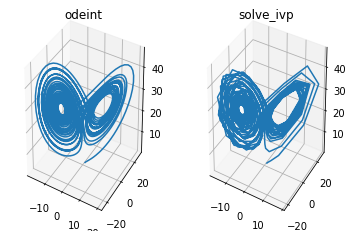

In [56]:
t_span = (0.0, 40.0)
t = np.arange(0.0, 40.0, 0.01)
 
result_odeint = odeint(lorenz, y0, t, p, tfirst=True)
result_solve_ivp = solve_ivp(lorenz, t_span, y0, args=p)
 
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(result_odeint[:, 0],
        result_odeint[:, 1],
        result_odeint[:, 2])
ax.set_title("odeint")
 
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot(result_solve_ivp.y[0, :],
        result_solve_ivp.y[1, :],
        result_solve_ivp.y[2, :])
ax.set_title("solve_ivp")